In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [3]:
#Ticker list = XLB, XLE, XLF, XLI, XLK, XLP, XLU, XLV, XLY

tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

etf = yf.Tickers(tickers)
#download timeseries data starting from 2011-01-01 inoplace =True

df = etf.history(start='2011-01-01', end='2021-01-01', actions = False)   
#keep close
df = df['Close']
df

[*********************100%%**********************]  9 of 9 completed


,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2011-01-03,29.541883,44.141174,10.376835,27.269770,21.118057,20.719328,20.057356,25.510998,32.104477
2011-01-04,29.343513,43.762409,10.364103,27.230940,21.200966,20.662853,20.152899,25.591242,31.926365
2011-01-05,29.412170,43.935738,10.485060,27.370722,21.325338,20.669910,20.025511,25.647413,32.189293
2011-01-06,29.259592,43.518471,10.415031,27.324123,21.449705,20.599314,20.044622,25.751743,31.994234
2011-01-07,29.229074,43.833023,10.325905,27.378473,21.350220,20.493427,20.114681,25.735695,31.977247
...,...,...,...,...,...,...,...,...,...
2020-12-24,67.295555,33.691647,27.345427,83.870201,125.748047,61.792698,55.780853,106.385071,154.235458
2020-12-28,67.032318,33.479523,27.477669,83.975052,127.170540,62.283550,56.026909,106.652298,155.993881
2020-12-29,66.872482,33.258575,27.383207,83.469917,126.566460,62.098335,56.017796,107.158127,156.042770


In [4]:
#returns data
returns = df.pct_change().fillna(0)

#expected return
er = returns.mean() * 252
#covariance matrix
cov = returns.cov() * 252

In [11]:
import scipy.optimize as sco
#function of sharpe ratio maximization porfolio weights 
def get_sharpe_weights(er, cov):
    #number of assets
    n = len(er)
    #initial weight guess
    init_guess = np.repeat(1/n, n)
    #constraints for non-leverage condition
    weights_sum_to_1 = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    #bounds for weights
    bounds = ((0, 1),) * n
    #objective function
    def neg_sharpe(weights, er, cov):
        return - (er @ weights) / np.sqrt(weights.T @ (cov @ weights))
    
    #perform optimization
    results = sco.minimize(neg_sharpe, init_guess, args=(er, cov), method='SLSQP', bounds=bounds, constraints=weights_sum_to_1)
    return results.x
    

In [15]:
#Weights for maximum sharpe ratio portfolio
sharpe_weights = get_sharpe_weights(er, cov)
#msr portfolio expected return
msr_er = np.dot(er, sharpe_weights)
#msr portfolio standard deviation
msr_sd = np.sqrt(np.dot(sharpe_weights.T, np.dot(cov, sharpe_weights)))
print('MSR Portfolio Expected Return: ', round(msr_er, 4))
print('MSR Portfolio Standard Deviation: ', round(msr_sd, 4))


MSR Portfolio Expected Return:  0.1703
MSR Portfolio Standard Deviation:  0.165


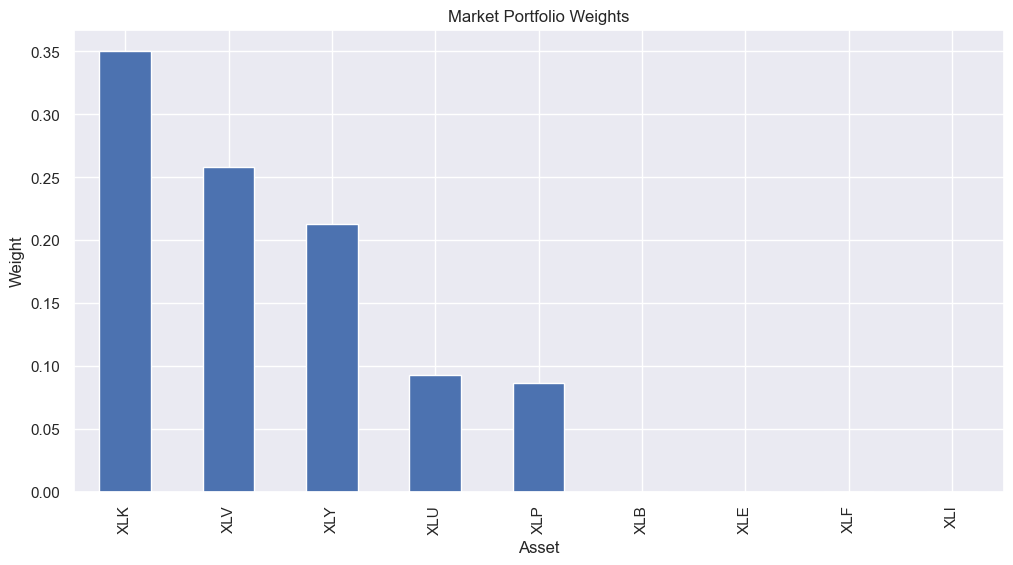

In [17]:
#Visualize market porfolio weights

msr_weights = pd.Series(np.round(sharpe_weights, 4), index=returns.columns)
msr_weights.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 6))
msr_weights.plot(kind='bar')
plt.xlabel('Asset')
plt.ylabel('Weight')
plt.title('Market Portfolio Weights')
plt.show()

In [19]:
#Capital market line statistics calculation function
def stat(weights):
    weights = np.array(weights)
    pret = np.sum(er * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return np.array([pret, pvol, pret / pvol])

#define objective fuction
def min_func_sharpe(weights):
    return stat(weights)[1]

#num of assets
n = len(er)
#level of rets to optimize for
target_ret = np.linspace(er.min(), er.max(), 50)
tvols = []

for tret in target_ret:
    #initial guess
    init_guess = np.repeat(1/n, n)
    #constraints
    cons = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'eq', 'fun': lambda weights: stat(weights)[0] - tret})
    #bounds
    bnds = ((0, 1),) * n
    #optimization
    opts = sco.minimize(min_func_sharpe, init_guess, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(opts['fun'])
tvols = np.array(tvols)


In [20]:
#data for left part of CML
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = target_ret[ind:]
evols[-1]

0.20396132946818998

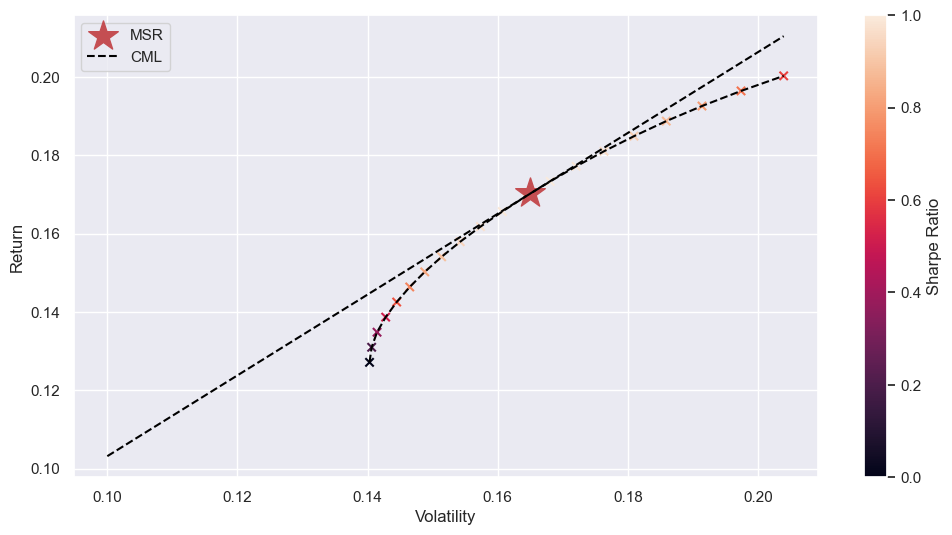

In [21]:
#CML data
x = np.linspace(0.1, evols[-1], 100)
y = (msr_er / msr_sd) * x

#visulize Efficient Frontier and CML
plt.figure(figsize=(12, 6))
plt.scatter(evols, erets, c=erets/evols, marker='x')
plt.plot(evols, erets, linestyle='--', color='black')
plt.scatter(msr_sd, msr_er, marker='*', color='r', s=500, label='MSR')
plt.plot(x, y, linestyle='--', color='black', label='CML')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()